### CNN + RNN Models  by : Khalid OUHMAID

In [48]:
import warnings  # ignore warning
warnings.filterwarnings("ignore")

In [49]:
# matplot
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [50]:

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [51]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import array
import re
import os

from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.tokenize import sent_tokenize, word_tokenize 

import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

In [52]:
# load the scrapped and labeled data
df = pd.read_csv("data/data.csv")

df.head() 

,label,content
0,1,Our most-broken and least-understood rules is ...
1,1,Perhaps what's worse than depression is not be...
2,1,A cop stopped me from killing myself last nigh...
3,1,Who else is just keeping themselves alive for ...
4,1,It doesn't get better. Fuck off with that shit...


## Text preprocessing

In [53]:
def clean_text(document):
    
   
    
    
    document = ' '.join([word.lower() for word in word_tokenize(document)]) # lowercase texts
    tokens = word_tokenize(document) # tokenize the document
    
    for i in range(0,len(tokens)):
        # remove whitespaces
        tokens[i] = tokens[i].strip()
        # remove html links
        tokens[i] = re.sub(r'\S*http\S*', '', tokens[i]) # remove links with http
        tokens[i] = re.sub(r'\S*\.org\S*', '', tokens[i]) # remove links with .org
        tokens[i] = re.sub(r'\S*\.com\S*', '', tokens[i]) # remove links with .com
        
        # remove subreddit titles (e.g /r/food)
        tokens[i] = re.sub(r'S*\/r\/\S*', '' ,tokens[i]) 
        
        # remove non-alphabet characters
        tokens[i] = re.sub("[^a-zA-Z]+", "", tokens[i])
        
        tokens[i] = tokens[i].strip() # remove whitespaces 
        
        # remove all blanks from the list
    while("" in tokens): 
        tokens.remove("") 
     
    return tokens

In [54]:
# call clean_text on df
# for each row in df
for i in range(0,len(df)):
    # use clean_text on the document/text stored in the content column
    clean = clean_text(df.loc[i,"content"])
    # joining the tokens together by whitespaces
    df.loc[i,"clean_content"] = ' '.join([token for token in clean])

In [55]:
df = df.dropna() # remove null data due to some deleted comments
df = df[df["clean_content"] != ''] # remove blank comments
df.to_csv('data/preprocessed_data.csv', index=False) # save the preprocessed data 

In [56]:
# select label and clean_content columns
df = df[["label","clean_content"]] 
df.reset_index(drop=True,inplace=True) 

In [57]:
# print the number of subjects that with depression
print("The number of subjects with depression is:", df[df["label"]==1].shape[0])
# print the number of subjects that are not depression
print("The number of subjects without depression is:", df[df["label"]==0].shape[0])

The number of subjects with depression is: 2719
The number of subjects without depression is: 2755


# Word embedding

## Creating a vocabulary

In [58]:
from collections import Counter

words = [] # create a list to store words in the data
for i in range(0,len(df)):
    tokens = df.loc[i,"clean_content"].split() 
    for token in tokens:
        words.append(token) 

In [59]:
vocab = Counter(words) # list the words and count their occurence
tokens = [k for k,c in vocab.items() if c >= 2] # remove words that appear only 1 time
vocab = tokens 

In [60]:
# The vocabulary size is the total number of words in our vocabulary, plus one for unknown words
vocab_size = len(set(vocab)) + 1
vocab_size

11685

## Removing words that are not in the vocabulary

In [61]:
for i in range(0,len(df)): # remove the words that are not in the vocab
    tokens = df.loc[i,"clean_content"].split() # split words by whitespaces
    
    df.loc[i,"clean_content"] = ' '.join([token for token in tokens if token in vocab])

## Splitting the training, validation and testing data

In [62]:
from sklearn.model_selection import train_test_split

# Divide the data into training (70%) and testing (30%)
df_train_valid, df_test = train_test_split(df, train_size=0.7, random_state=42, stratify=df["label"])

# Divide the trainning data into training (70%) and validation (30%)
df_train, df_valid = train_test_split(df_train_valid, train_size=0.7, random_state=42, stratify=df_train_valid["label"])

In [63]:
df_train.reset_index(drop=True,inplace=True) # reset index
df_valid.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [64]:
# print training data dimensions
df_train.shape

(2681, 2)

In [65]:
train_docs = [] # a list to store comments from the training set
valid_docs = [] # a list to store comments from the validation set
test_docs = [] # a list to store comments from the testing set

for i in range(0,len(df_train)):
    text = df_train.loc[i,"clean_content"] # selecting each comment in each row 
    train_docs.append(text)  # append each comment to a list of documents 
    
for i in range(0,len(df_valid)):
    text = df_valid.loc[i,"clean_content"]
    valid_docs.append(text)
    
for i in range(0,len(df_test)):
    text = df_test.loc[i,"clean_content"]
    test_docs.append(text)

In [66]:
docs = train_docs + valid_docs + test_docs

In [67]:
max_length = max([len(document.split()) for document in docs])
# print max_length
max_length

3415

## Keras embedding layer

In [68]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(docs)

tokenizer_vocab = tokenizer.word_index

In [69]:
def defineXY(df, docs):
   
    
    # converting comments into numeric vectors using layer embedding
    encoded_docs = tokenizer.texts_to_sequences(docs) 
    
    # save each vectorized comment into X_label array
   
    X_label = pad_sequences(encoded_docs, maxlen=max_length, padding='pre') 
    
    # saving the label for each comment into an array
    df_label = df["label"]
    y_label = array([df_label[i] for i in range(0,len(df_label))]) # save target label into an array
    
    return X_label, y_label

In [70]:
# call defineXY on the training, validation and testing data
Xtrain, ytrain = defineXY(df_train, train_docs)
Xvalid, yvalid = defineXY(df_valid, valid_docs)
Xtest, ytest = defineXY(df_test, test_docs)

### Train the Word2Vec model

In [71]:
sentences = [] # create a list to store sentences of tokens
for item in docs: 
    tokens = item.split() 
    sentences.append(tokens) # append the list of tokens in a sentence to sentences

In [72]:
from gensim.models import Word2Vec
# train the sentences with Word2Vec model

# we only count words that appear at least 2 times
model_word2vec = Word2Vec(sentences, window=5, workers=8, min_count=2)

In [73]:
print(model_word2vec) 

Word2Vec(vocab=11684, vector_size=100, alpha=0.025)


In [74]:
from os import listdir
# save model
filename = 'word2vec_embedding/embedding_word2vec.txt'
model_word2vec.wv.save_word2vec_format(filename, binary=False)

In [75]:
def load_embedding(filename):
    
   
    
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
      
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [76]:
raw_embedding = load_embedding('word2vec_embedding/embedding_word2vec.txt')

### Mapping the embedding vectors

In [77]:
# create a weight matrix 
def get_weight_matrix(embedding, vocab_size):
  
    
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer integer mapping
    for word, i in tokenizer_vocab.items(): 
        if i > vocab_size:
            continue
        vector = embedding.get(word) # get the word in the embedding file
        if vector is not None: # word not found will be returned zero
            weight_matrix[i] = vector 
    return weight_matrix

In [78]:
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, vocab_size)

# Building Neural Network Model

In [79]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint_cb_CNN_keras = ModelCheckpoint(   # for CNN using Keras API Tokenizer
    filepath = "../model/CNN_keras.h5",
    save_best_only=True)     




early_stopping_cb = EarlyStopping(
    patience=5,  # stopping after 5 epochs without improvement
    restore_best_weights=True)

reduce_lr_on_plateau_cb = ReduceLROnPlateau(
    verbose = 1,
    factor=0.1,  
    patience=2)  # after 2 epochs without improvement in validation loss

## CNN and Keras embedding layer

In [80]:
model = Sequential()
# add the embedding layer
model.add(Embedding(vocab_size, 100, input_length=max_length)) 
# add the convolutional layer
model.add(Conv1D(filters=32, kernel_size=8, padding="same", activation='relu')) # 32
# add the GAP layer
model.add(GlobalAveragePooling1D())
model.add(Flatten())

# add a fully connected layer with the activation function as relu
model.add(Dense(10, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3415, 100)         1168500   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3415, 128)         102528    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,272,329
Trainable params: 1,272,329
Non-trainable params: 0
____________________________________________

In [81]:
# compile network
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=10 ** -3), metrics=['accuracy'])
# fit network
history_CNN_keras = model.fit(Xtrain, ytrain, epochs=100, validation_data=(Xvalid, yvalid), 
            callbacks=[model_checkpoint_cb_CNN_keras, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/100
84/84 [==============================] - 58s 686ms/step - loss: 0.6500 - accuracy: 0.6371 - val_loss: 0.5563 - val_accuracy: 0.7670
Epoch 2/100
84/84 [==============================] - 57s 681ms/step - loss: 0.4914 - accuracy: 0.7811 - val_loss: 0.4290 - val_accuracy: 0.8296
Epoch 3/100
84/84 [==============================] - 53s 631ms/step - loss: 0.3565 - accuracy: 0.8594 - val_loss: 0.3209 - val_accuracy: 0.8678
Epoch 4/100
84/84 [==============================] - 53s 633ms/step - loss: 0.2391 - accuracy: 0.9112 - val_loss: 0.2514 - val_accuracy: 0.9096
Epoch 5/100
84/84 [==============================] - 52s 625ms/step - loss: 0.1673 - accuracy: 0.9459 - val_loss: 0.2179 - val_accuracy: 0.9243
Epoch 6/100
84/84 [==============================] - 56s 672ms/step - loss: 0.1204 - accuracy: 0.9620 - val_loss: 0.1861 - val_accuracy: 0.9357
Epoch 7/100
84/84 [==============================] - 59s 706ms/step - loss: 0.0860 - accuracy: 0.9772 - val_loss: 0.1806 - val_accuracy:

### Model evaluation (CNN and Keras)


In [82]:
model = keras.models.load_model("model/CNN_keras.h5")

# evaluating the model
loss, accuracy = model.evaluate(Xtest, ytest, verbose = 0)

print("loss:", loss)
print("accuracy:", accuracy)

loss: 0.1927167773246765
accuracy: 0.9360924959182739


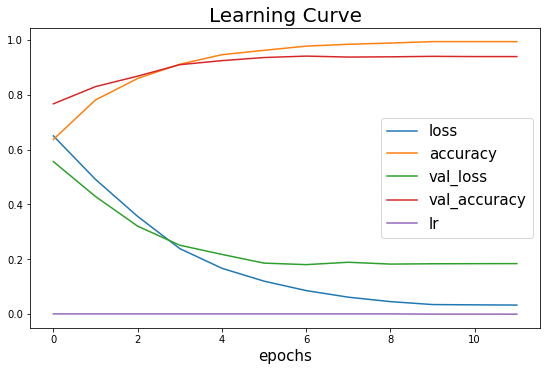

In [83]:
pd.DataFrame(history_CNN_keras.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.title('Learning Curve')
plt.xlabel('epochs')

plt.show()

## CNN and Word2Vec

In [43]:
# create the pre-trained embedding layer by using the embedding_vectors as the weights
# trainable is set as False to freeze the pre-trained layer
embedding_layer = Embedding(vocab_size, 100, embeddings_initializer=keras.initializers.Constant(embedding_vectors), input_length=max_length, trainable=False)

In [42]:
model = Sequential()
# add the embedding layer
model.add(embedding_layer) 
# add the convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding="same", activation='relu'))
# add the GAP layer
model.add(GlobalAveragePooling1D())
# add a fully connected layer with the activation function as relu
model.add(Dense(10, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3415, 100)         1168500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3415, 128)         64128     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,233,929
Trainable params: 65,429
Non-trainable params: 1,168,500
_________________________________________________________________


In [45]:
model_checkpoint_cb_CNN_word2vec = ModelCheckpoint(   # for CNN using word2vec
    filepath = "model/CNN_word2vec.h5",
    save_best_only=True)   

In [46]:
# compile network
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=10 ** -3), metrics=['accuracy'])
# fit network
history_CNN_word2vec = model.fit(Xtrain, ytrain, epochs=100, validation_data=(Xvalid, yvalid),
            callbacks=[model_checkpoint_cb_CNN_word2vec, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/100
84/84 [==============================] - 28s 334ms/step - loss: 0.5824 - accuracy: 0.7262 - val_loss: 0.4857 - val_accuracy: 0.8191
Epoch 2/100
84/84 [==============================] - 29s 340ms/step - loss: 0.4402 - accuracy: 0.8333 - val_loss: 0.4321 - val_accuracy: 0.8478
Epoch 3/100
84/84 [==============================] - 28s 336ms/step - loss: 0.4091 - accuracy: 0.8407 - val_loss: 0.3974 - val_accuracy: 0.8522
Epoch 4/100
84/84 [==============================] - 30s 352ms/step - loss: 0.3889 - accuracy: 0.8530 - val_loss: 0.3867 - val_accuracy: 0.8461
Epoch 5/100
84/84 [==============================] - 33s 387ms/step - loss: 0.3690 - accuracy: 0.8549 - val_loss: 0.3694 - val_accuracy: 0.8713
Epoch 6/100
84/84 [==============================] - 38s 458ms/step - loss: 0.3611 - accuracy: 0.8639 - val_loss: 0.3533 - val_accuracy: 0.8678
Epoch 7/100
84/84 [==============================] - 37s 437ms/step - loss: 0.3434 - accuracy: 0.8691 - val_loss: 0.3549 - val_accuracy:

In [47]:
# Load the model
model = keras.models.load_model("model/CNN_word2vec.h5")

# evaluating the model
loss, accuracy = model.evaluate(Xtest, ytest, verbose = 0)

# print loss and accuracy
print("loss:", loss)
print("accuracy:", accuracy)

loss: 0.26462045311927795
accuracy: 0.8989652991294861


## RNN and Keras embedding layer

In [35]:
# define model
# create a squential
model = Sequential()
# add the embedding layer
model.add(Embedding(vocab_size, 100, input_length=max_length))
# add the LSTM layer
model.add(LSTM(100))
# add drop out to prevent overfitting
model.add(Dropout(0.2))
# add the output layer
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3415, 100)         1168500   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,249,001
Trainable params: 1,249,001
Non-trainable params: 0
_________________________________________________________________


### Compiling and training the model (RNN and Keras)

In [37]:
# ModelCheckpoint callback
  

model_checkpoint_cb_RNN_keras = ModelCheckpoint(  # for RNN using Keras API Tokenizer
    filepath = "../model/RNN_keras.h5",   
    save_best_only=True)
   

model_checkpoint_cb_RNN_word2vec = ModelCheckpoint(  # for RNN using word2vec
    filepath = "../model/RNN_word2vec.h5",   
    save_best_only=True)

In [38]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=10 ** -3), metrics=['accuracy'])
history_RNN_keras = model.fit(Xtrain, ytrain, validation_data=(Xvalid, yvalid), epochs=100, 
                        callbacks=[model_checkpoint_cb_RNN_keras, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/100
84/84 [==============================] - 345s 4s/step - loss: 0.5189 - accuracy: 0.7285 - val_loss: 0.2969 - val_accuracy: 0.8922
Epoch 2/100
84/84 [==============================] - 354s 4s/step - loss: 0.2036 - accuracy: 0.9276 - val_loss: 0.2739 - val_accuracy: 0.8896
Epoch 3/100
84/84 [==============================] - 361s 4s/step - loss: 0.0995 - accuracy: 0.9713 - val_loss: 0.2290 - val_accuracy: 0.9183
Epoch 4/100
84/84 [==============================] - 359s 4s/step - loss: 0.1862 - accuracy: 0.9407 - val_loss: 0.5712 - val_accuracy: 0.7061
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9209
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
84/84 [==============================] - 375s 4s/step - loss: 0.2091 - accuracy: 0.9209 - val_loss: 0.3113 - val_accuracy: 0.8817
Epoch 6/100
84/84 [==============================] - 396s 5s/step - loss: 0.0456 - accuracy: 0.9896 - val_loss: 0.2372 - val_a

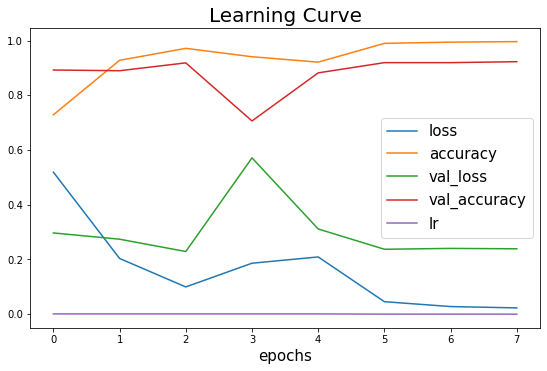

In [39]:
pd.DataFrame(history_RNN_keras.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.title('Learning Curve')
plt.xlabel('epochs')

plt.show()

### Model evaluation (RNN and Keras)

In [40]:
# Load the model
model = keras.models.load_model("model/RNN_keras.h5")

# evaluating the model
loss, accuracy = model.evaluate(Xtest, ytest, verbose = 0)

# print loss and accuracy
print("loss:", loss)
print("accuracy:", accuracy)

loss: 0.2635047733783722
accuracy: 0.923919677734375


## RNN and Word2Vec

In [44]:
# define model
# create a squential
model = Sequential()
# add the embedding layer
model.add(embedding_layer) 
# add the LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))








# add the output layer
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3415, 100)         1168500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,249,001
Trainable params: 80,501
Non-trainable params: 1,168,500
_________________________________________________________________
